In [177]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load



import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# импортируем библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

  Using cached LightAutoML-0.2.16-py3-none-any.whl (262 kB)
INFO: pip is looking at multiple versions of lightautoml to determine which version is compatible with other requirements. This could take a while.
/kaggle/input/sf-booking/hotels_test.csv
/kaggle/input/sf-booking/hotels_train.csv
/kaggle/input/sf-booking/submission.csv


# 1. Постановка задачи


**> Представьте, что вы работаете дата-сайентистом в компании Booking. Одна из проблем компании — это нечестные отели, которые накручивают себе рейтинг. Одним из способов обнаружения таких отелей является построение модели, которая предсказывает рейтинг отеля. Если предсказания модели сильно отличаются от фактического результата, то, возможно, отель ведёт себя нечестно, и его стоит проверить.**

> #  Признаки:

* hotel_address — адрес отеля;
* review_date — дата, когда рецензент разместил соответствующий отзыв;
* average_score — средний балл отеля, рассчитанный на основе последнего комментария за последний год;
* hotel_name — название отеля;
* reviewer_nationality — страна рецензента;
* negative_review — отрицательный отзыв, который рецензент дал отелю;
* review_total_negative_word_counts — общее количество слов в отрицательном отзыв;
* positive_review — положительный отзыв, который рецензент дал отелю;
* review_total_positive_word_counts — общее количество слов в положительном отзыве.
* reviewer_score — оценка, которую рецензент поставил отелю на основе своего опыта;
* total_number_of_reviews_reviewer_has_given — количество отзывов, которые рецензенты дали в прошлом;
* total_number_of_reviews — общее количество действительных отзывов об отеле;
* tags — теги, которые рецензент дал отелю;
* days_since_review — количество дней между датой проверки и датой очистки;
* additional_number_of_scoring — есть также некоторые гости, которые просто поставили оценку сервису, но не оставили отзыв. Это число указывает, сколько там действительных оценок без проверки.
* lat — географическая широта отеля;
* lng — географическая долгота отеля.

In [83]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [84]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [85]:
# Подгрузим наши данные из соревнования

DATA_DIR = '/kaggle/input/sf-booking/'
df_train = pd.read_csv(DATA_DIR + 'hotels_train.csv')
df_test = pd.read_csv(DATA_DIR + 'hotels_test.csv')
sample_submission = pd.read_csv(DATA_DIR + 'submission.csv')

In [138]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 386496 entries, 0 to 386802
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386496 non-null  object 
 1   additional_number_of_scoring                386496 non-null  int64  
 2   review_date                                 386496 non-null  object 
 3   average_score                               386496 non-null  float64
 4   hotel_name                                  386496 non-null  object 
 5   reviewer_nationality                        386496 non-null  object 
 6   negative_review                             386496 non-null  object 
 7   review_total_negative_word_counts           386496 non-null  int64  
 8   total_number_of_reviews                     386496 non-null  int64  
 9   positive_review                             386496 non-null  object 
 

In [139]:
df_train.head(3)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng,sample
0,Stratton Street Mayfair Westminster Borough London W1J 8LT United Kingdom,581,2/19/2016,8.400,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.000,"[' Leisure trip ', ' Couple ', ' Studio Suite ', ' Stayed 2 nights ', ' Submitted from a mobile device ']",531 day,51.508,-0.144,1
1,130 134 Southampton Row Camden London WC1B 5AF United Kingdom,299,1/12/2017,8.300,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.300,"[' Business trip ', ' Couple ', ' Standard Double Room ', ' Stayed 1 night ']",203 day,51.521,-0.123,1
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,10/18/2016,8.900,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,0,14,7.500,"[' Leisure trip ', ' Solo traveler ', ' Modern Double Room Echo ', ' Stayed 3 nights ', ' Submitted from a mobile device ']",289 day,48.845,2.326,1


In [140]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               128935 non-null  object 
 1   additional_number_of_scoring                128935 non-null  int64  
 2   review_date                                 128935 non-null  object 
 3   average_score                               128935 non-null  float64
 4   hotel_name                                  128935 non-null  object 
 5   reviewer_nationality                        128935 non-null  object 
 6   negative_review                             128935 non-null  object 
 7   review_total_negative_word_counts           128935 non-null  int64  
 8   total_number_of_reviews                     128935 non-null  int64  
 9   positive_review                             128935 non-null  object 
 

In [141]:
df_test.head(3)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng,sample,reviewer_score
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.100,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel that sold drinking water etc but not necessity Would recommend if like us you arrive late at night to bring drinks from plane airport as there s no shop nearby There is a minibar though if you want to pay those prices,52,16670,Hotel was great clean friendly staff free breakfast every morning with good selection good wifi connection nice sized room with bath fridge in room Personally loved the fact that the hotel isn t in the city centre but is literally next to a train station that you can easily get to and from the airport city Would definitely stay again,62,1,"[' Leisure trip ', ' Couple ', ' Double Room ', ' Stayed 2 nights ']",13 days,45.533,9.171,0,0
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Netherlands,612,12/12/2016,8.600,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ', ' Stayed 1 night ']",234 day,52.386,4.834,0,0
2,Mallorca 251 Eixample 08008 Barcelona Spain,46,11/26/2015,8.300,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,5,15,"[' Business trip ', ' Solo traveler ', ' Twin Room ', ' Stayed 1 night ', ' Submitted from a mobile device ']",616 day,41.393,2.162,0,0


In [143]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   reviewer_score  128935 non-null  int64
 1   id              128935 non-null  int64
dtypes: int64(2)
memory usage: 2.0 MB


In [142]:
sample_submission.head(3)

,reviewer_score,id
0,1,488440
1,10,274649
2,3,374688


**Для обработки признаков соединим тренировочный и тестовый датасет в один, для разделения добавим общий признак sample, который будет равен 1 для тренировочных данных и 0 для тестовых. Так же в тестовом датасете создадим целевой признак reviewer_score и заполним его нулями.**

In [146]:
df_train['sample'] = 1
df_test['sample'] = 0
df_test['reviewer_score'] = 0

hotels = pd.concat([df_train, df_test], sort=False).reset_index(drop=True)

In [147]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515431 non-null  object 
 1   additional_number_of_scoring                515431 non-null  int64  
 2   review_date                                 515431 non-null  object 
 3   average_score                               515431 non-null  float64
 4   hotel_name                                  515431 non-null  object 
 5   reviewer_nationality                        515431 non-null  object 
 6   negative_review                             515431 non-null  object 
 7   review_total_negative_word_counts           515431 non-null  int64  
 8   total_number_of_reviews                     515431 non-null  int64  
 9   positive_review                             515431 non-null  object 
 

#  2. Проектирование признаков

In [150]:
# создаем дополнительный признак для заполнения пропусков в координатах - страна и город
data['hot_addr_3w'] = data['hotel_address'].apply(lambda x: str(str(x).split()[-3:]))

In [152]:
# заполняем пропуски средним значением координаты в том же городе той же страны
data['lat'] = data['lat'].fillna(data.groupby('hot_addr_3w')['lat'].transform('mean'))
data['lng'] = data['lng'].fillna(data.groupby('hot_addr_3w')['lng'].transform('mean'))

In [153]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 19 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515431 non-null  object 
 1   additional_number_of_scoring                515431 non-null  int64  
 2   review_date                                 515431 non-null  object 
 3   average_score                               515431 non-null  float64
 4   hotel_name                                  515431 non-null  object 
 5   reviewer_nationality                        515431 non-null  object 
 6   negative_review                             515431 non-null  object 
 7   review_total_negative_word_counts           515431 non-null  int64  
 8   total_number_of_reviews                     515431 non-null  int64  
 9   positive_review                             515431 non-null  object 
 

In [154]:
data.nunique(dropna=False)

hotel_address                                   1493
additional_number_of_scoring                     480
review_date                                      731
average_score                                     34
hotel_name                                      1492
reviewer_nationality                             227
negative_review                               330011
review_total_negative_word_counts                402
total_number_of_reviews                         1142
positive_review                               412601
review_total_positive_word_counts                365
total_number_of_reviews_reviewer_has_given       198
tags                                           55242
days_since_review                                731
lat                                             1484
lng                                             1484
sample                                             2
reviewer_score                                    38
hot_addr_3w                                   

In [155]:
# применяем бинарное кодирование для признака национальности автора обзора
import category_encoders as ce # импорт для работы с кодировщиком
bin_encoder = ce.BinaryEncoder(cols=['reviewer_nationality']) # указываем столбец для кодирования
type_bin = bin_encoder.fit_transform(data['reviewer_nationality'])
data = pd.concat([data, type_bin], axis=1)

In [156]:
# извлекаем возможные составляющие из даты отзыва
data['review_date'] = pd.to_datetime(data['review_date'])
data['timestamp'] = data['review_date'].apply(lambda x: x.timestamp())
data['month'] = data['review_date'].apply(lambda x: x.month)
data['year'] = data['review_date'].apply(lambda x: x.year)
data['weekday'] = data['review_date'].apply(lambda x: x.weekday())

In [157]:
# выделяем дни из поля с информацией, сколько дней прошло с отзыва
data['days_since_review_1'] = data['days_since_review'].apply(lambda x: int(str(x.split()[0])))

In [158]:
# выносим в отдельный признак наличие хотя бы одного слова в положительном и в отрицательном отзывах
data['negative'] = data['review_total_negative_word_counts'].apply(lambda x: 0 if x==0 else 1)
data['positive'] = data['review_total_positive_word_counts'].apply(lambda x: 0 if x==0 else 1)

In [159]:
# считаем количество тегов в отзыве
data['tags_num'] = data['tags'].apply(lambda x: 
    len(x.replace("[","").replace("]","").replace("' ","").replace(" '","").split(sep=', ')))

In [160]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 35 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   hotel_address                               515431 non-null  object        
 1   additional_number_of_scoring                515431 non-null  int64         
 2   review_date                                 515431 non-null  datetime64[ns]
 3   average_score                               515431 non-null  float64       
 4   hotel_name                                  515431 non-null  object        
 5   reviewer_nationality                        515431 non-null  object        
 6   negative_review                             515431 non-null  object        
 7   review_total_negative_word_counts           515431 non-null  int64         
 8   total_number_of_reviews                     515431 non-null  int64        

In [161]:
data.head()

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,...,reviewer_nationality_6,reviewer_nationality_7,timestamp,month,year,weekday,days_since_review_1,negative,positive,tags_num
0,Via Senigallia 6 20161 Milan Italy,904,2017-07-21,8.100,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel that sold drinking water etc but not necessity Would recommend if like us you arrive late at night to bring drinks from plane airport as there s no shop nearby There is a minibar though if you want to pay those prices,52,16670,Hotel was great clean friendly staff free breakfast every morning with good selection good wifi connection nice sized room with bath fridge in room Personally loved the fact that the hotel isn t in the city centre but is literally next to a train station that you can easily get to and from the airport city Would definitely stay again,...,0,1,1500595200.000,7,2017,4,13,1,1,4
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Netherlands,612,2016-12-12,8.600,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,...,1,0,1481500800.000,12,2016,0,234,1,0,4
2,Mallorca 251 Eixample 08008 Barcelona Spain,46,2015-11-26,8.300,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,...,1,1,1448496000.000,11,2015,3,616,1,1,5
3,Piazza Della Repubblica 17 Central Station 20124 Milan Italy,241,2015-10-17,9.100,Hotel Principe Di Savoia,United States of America,No Negative,0,1543,Everything including the nice upgrade The Hotel has been revamped and what a surprise Love every second of it including in room dining which was excellent,...,0,0,1445040000.000,10,2015,5,656,0,1,4
4,Singel 303 309 Amsterdam City Center 1012 WJ Amsterdam Netherlands,834,2016-05-16,9.100,Hotel Esther a,United Kingdom,No Negative,0,4687,Lovely hotel v welcoming staff,...,0,1,1463356800.000,5,2016,0,444,0,1,5


**Получим количество уникальных отелей по названиям**

/tmp/ipykernel_32/1624597386.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data.drop(['sample'], axis=1).corr(), annot=True)


<Axes: >

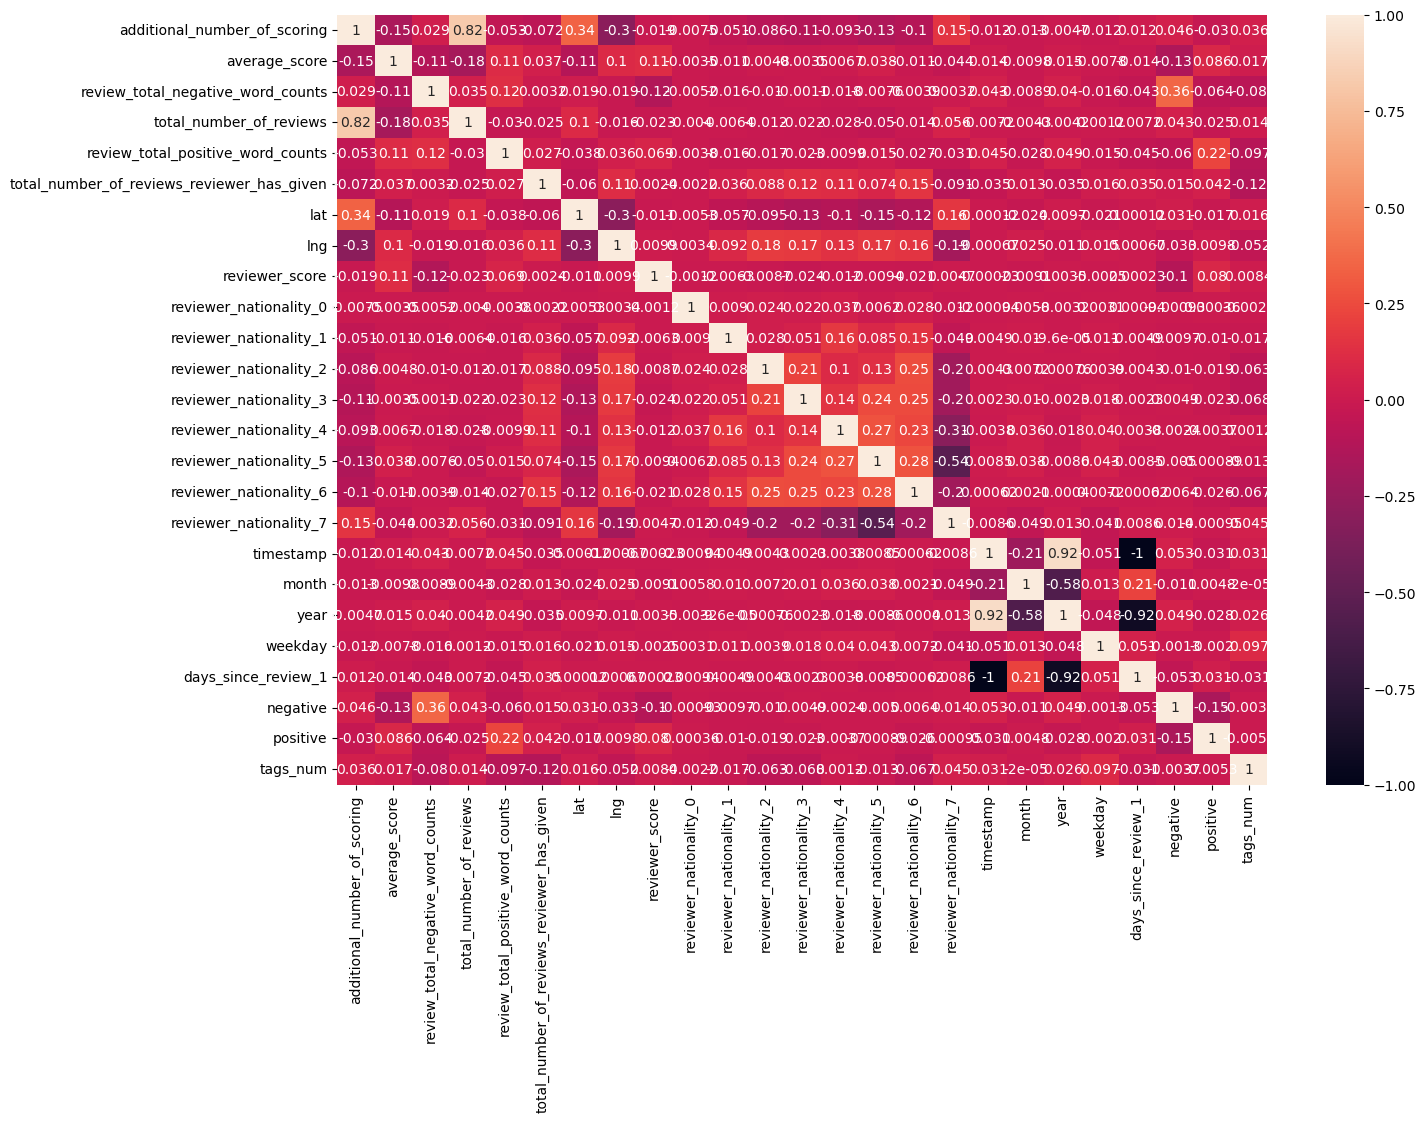

In [163]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(data.drop(['sample'], axis=1).corr(), annot=True)

In [164]:
# убираем признаки которые еще не успели обработать, 
# модель на признаках с dtypes "object" обучаться не будет, просто выберем их и удалим
object_columns = [s for s in data.columns if data[s].dtypes == 'object']
# также удаляем тип datetime
object_columns += ['review_date']
data.drop(object_columns, axis = 1, inplace=True)

In [165]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 26 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515431 non-null  int64  
 1   average_score                               515431 non-null  float64
 2   review_total_negative_word_counts           515431 non-null  int64  
 3   total_number_of_reviews                     515431 non-null  int64  
 4   review_total_positive_word_counts           515431 non-null  int64  
 5   total_number_of_reviews_reviewer_has_given  515431 non-null  int64  
 6   lat                                         515431 non-null  float64
 7   lng                                         515431 non-null  float64
 8   sample                                      515431 non-null  int64  
 9   reviewer_score                              515431 non-null  float64
 

In [166]:
# Теперь выделим тестовую часть
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values            # наш таргет
X = train_data.drop(['reviewer_score'], axis=1)

In [167]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [168]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128935, 25), (386496, 25), (386496, 24), (309196, 24), (77300, 24))

In [169]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [170]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [171]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.3min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.6s finished


In [172]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAPE:', metrics.mean_absolute_error(y_test, y_pred))

MAPE: 0.9388873413725125


In [181]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_32/3630654229.py", line 4, in <module>
    feat_importances.nlargest(15).plot(kind='barh')
  File "/opt/conda/lib/python3.10/site-packages/pandas/plotting/_core.py", line 920, in __call__
    return plot_backend.plot(data, x=x, y=y, kind=kind, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/pandas/plotting/_core.py", line 1886, in _get_plot_backend
  File "/opt/conda/lib/python3.10/site-packages/pandas/plotting/_core.py", line 1817, in _load_backend
    # Fall back to unregistered, module name approach.
ImportError: matplotlib is required for plotting when the default backend "matplotlib" is selected.

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/IPython/co

In [182]:
test_data.sample(10)

,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,lat,lng,reviewer_score,reviewer_nationality_0,...,reviewer_nationality_6,reviewer_nationality_7,timestamp,month,year,weekday,days_since_review_1,negative,positive,tags_num
8710,918,8.400,0,4117,7,4,51.514,-0.101,0.000,0,...,0,1,1446336000.000,11,2015,6,641,0,1,5
87277,482,9.000,0,3158,10,1,52.378,4.897,0.000,0,...,0,1,1498003200.000,6,2017,2,43,0,1,5
117010,838,8.400,0,3274,7,6,51.496,-0.145,0.000,0,...,1,1,1443571200.000,9,2015,2,673,0,1,4
4198,995,8.100,41,3826,5,2,51.504,-0.033,0.000,0,...,0,1,1474761600.000,9,2016,6,312,1,1,4
76840,42,8.100,0,494,72,8,48.887,2.345,0.000,0,...,0,0,1475366400.000,10,2016,6,305,0,1,4
127838,1258,9.400,0,4204,4,7,51.502,-0.000,0.000,0,...,0,1,1481500800.000,12,2016,0,234,0,1,5
37813,353,8.500,35,3583,89,12,48.845,2.375,0.000,0,...,0,1,1457913600.000,3,2016,0,507,1,1,4
74115,740,7.400,0,5575,16,15,48.879,2.356,0.000,0,...,1,0,1480896000.000,12,2016,0,241,0,1,5
38993,230,8.600,17,1703,22,21,48.872,2.324,0.000,0,...,0,0,1501632000.000,8,2017,2,1,1,1,5
44097,16,8.400,0,167,5,15,48.875,2.287,0.000,0,...,1,1,1453939200.000,1,2016,3,553,0,1,5


In [183]:
test_data = test_data.drop(['reviewer_score'], axis=1)

In [184]:
sample_submission

,reviewer_score,id
0,1,488440
1,10,274649
2,3,374688
3,10,404352
4,9,451596
...,...,...
128930,7,495812
128931,1,315577
128932,3,511968
128933,6,303386


In [185]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    2.5s finished


In [186]:
predict_submission

array([8.928, 7.408, 8.322, ..., 8.202, 9.588, 7.38 ])

In [187]:
list(sample_submission)

['reviewer_score', 'id']

In [188]:
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,reviewer_score,id
0,8.928,488440
1,7.408,274649
2,8.322,374688
3,9.616,404352
4,9.708,451596
5,8.331,302161
6,8.215,317079
7,7.842,13963
8,8.786,159785
9,8.010,195089


**Показатель MAPE сосотавляет  0.938, что лучше, чем показатель базового решения.**